# MagNet: Model the Geomagnetic Field

This notebook describes a convolutional neural network approach to forecasting the disturbance storm time index. This is based on the first-place solution to a competition held by the National Oceanic and Atmospheric Association (NOAA) and National Aeronatics and Space Administration (NASA) in 2020-21 (https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/).

### Imports

The model is built with tensorflow, using the keras framework. We also use some common data science packages, including `numpy` and `pandas`, to prepare the data, and `matplotlib` for visualisation.

In [1]:
#Update sklearn Library
!pip install -U scikit-learn

  Using cached scikit_learn-1.0.1-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

### Download the data

All the competition data is now publically available. ``public.zip`` is the data that was provided for training in the competition. ``private.zip`` is the unseen data used for scoring. The private data was divided into 2 parts: some was used for a public leaderboard visible during the competition, and the remainder was used for the final ranking.

To save memory, we load only the public data now. We will load the private data later.

We index the data by period and timedelta, so that we can merge on these indexes later.

In [3]:
%%capture
%%bash
#download the data
if [ ! -d "data" ]; then
  wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
  unzip public.zip
  wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
  unzip private.zip
  mkdir data
  mv public data
  mv private data
fi

In [4]:
# read the data
DATA_PATH = Path("data/public")
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")

In [5]:
#Data indexing according to the timestamps
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

### Visualisations

We plot a short period (1000 minutes) of some of the key features. Note the frequent gaps in the data; we will need to fill these for training and prediciton.

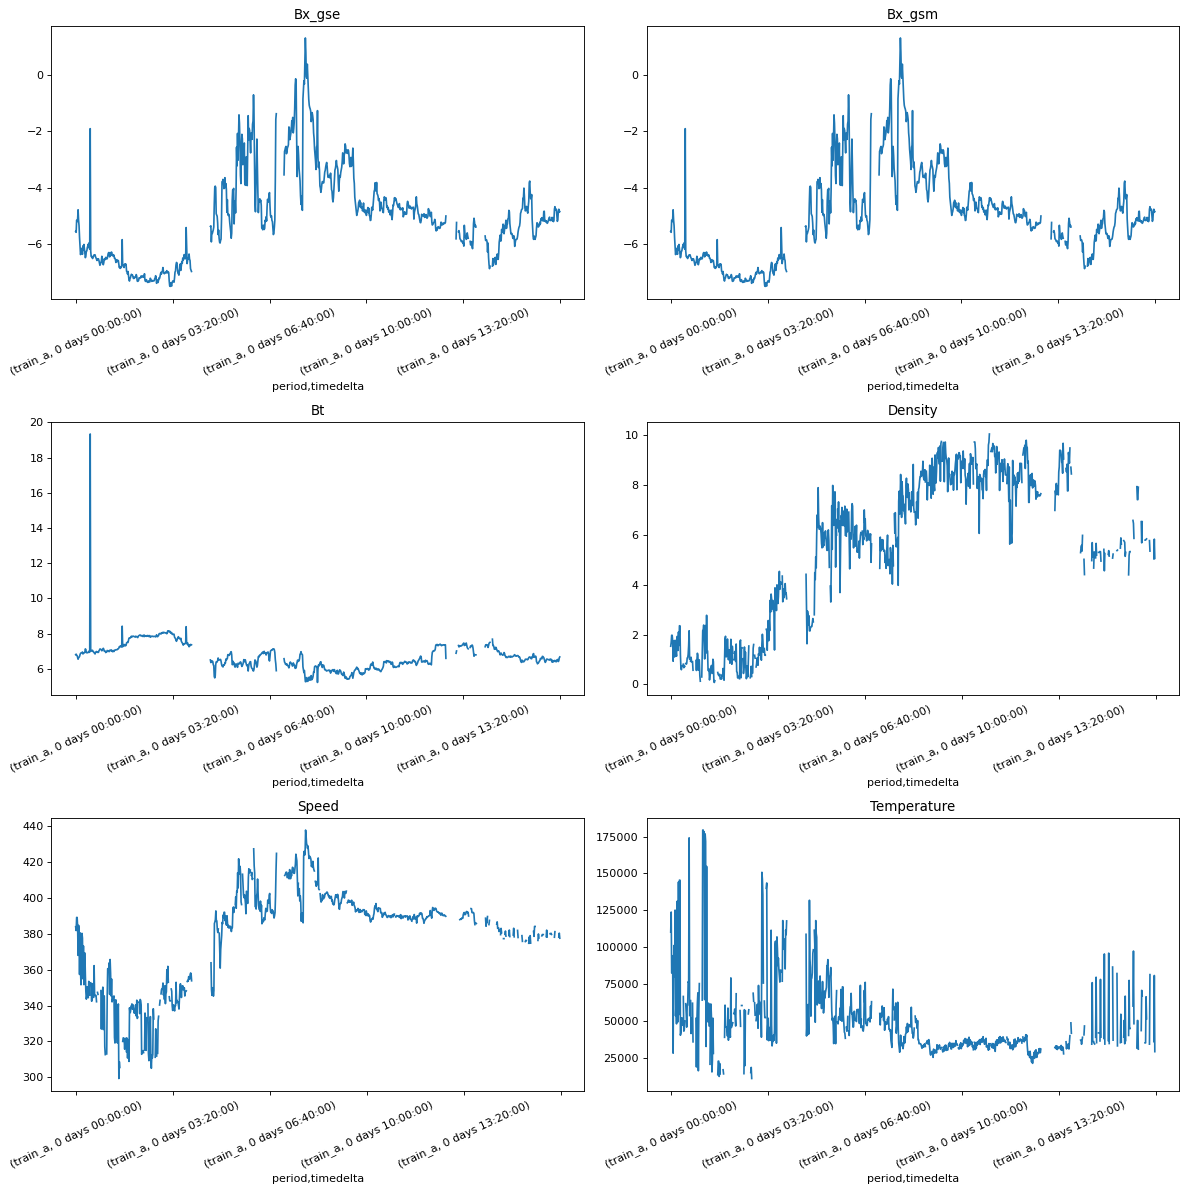

In [6]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

### Feature correlations

We plot the correlations between different features. The components of the solar wind in different co-ordinate systems are highly correlated (as expected). We also see a strong correlation between speed and temperature.

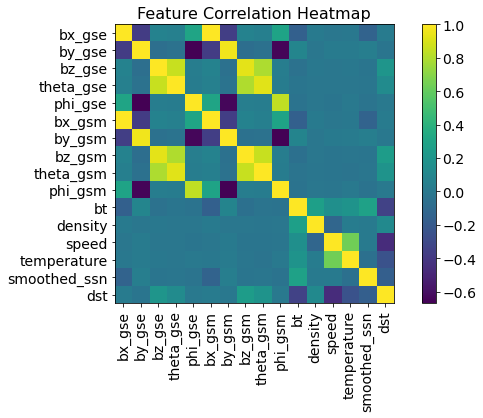

In [7]:
corr = solar_wind.join(sunspots).join(dst).fillna(method="pad").corr()
corr = solar_wind.join(sunspots).join(dst).fillna(method="bfill").corr()
plt.figure(figsize=(10, 5))
plt.matshow(corr, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

### Preprocessing

We use all the solar wind and sunspots features (but not the satellite position data). We impute missing data using the most frequent value for each feature.

To reduce the size of the training data, we will aggregate the features by hour and calculate the mean and standard deviation in each hour.

In [8]:
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.random import set_seed
seed(2020)
set_seed(2021)
import numpy as np
from sklearn.preprocessing import StandardScaler,power_transform
from sklearn.impute import  SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PowerTransformer
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gse",
    "by_gse",
    "bz_gse",
    "phi_gse",
    "theta_gse",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "phi_gsm",
    "theta_gsm",
    "speed",
    "density",
]

# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    
    + ["smoothed_ssn"] 
)


def impute_features(feature_df, imp = None):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # missing solar wind values imputation using most-frequent strategy
    feature_df=feature_df.reset_index()
    cols = feature_df.columns[2:]
    if imp == None:
      imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
      imp.fit(feature_df[cols])
    temp = imp.transform(feature_df[cols])
    feature_df[cols] = temp
    feature_df.timedelta = pd.to_timedelta(feature_df.timedelta)
    feature_df.set_index(["period", "timedelta"], inplace=True)
    return feature_df , imp


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None ,subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
    # aggregate solar wind data and join with sunspots
    
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed, imp = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler, imp

In [9]:
features, scaler, imputer = preprocess_features(solar_wind, sunspots , subset=SOLAR_WIND_FEATURES)
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

### Prepare the targets

We need to predict the DST values at time ``t`` and ``t + 1``. Since we have aggregated the features so that the label ``t`` corresponds to the hour _beginning_ at ``t``, we need to shift the labels back by 1 hour for time ``t`` and 2 hours for ``t + 1``.

In [10]:

YCOLS = ["t0", "t1"]
def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]

labels = process_labels(dst)
data = labels.join(features)

### Separate data for validation

We will leave some data out from the training set to benchmark model performance.

In [11]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the first `test_per_period` rows from each period to test
    test = data.groupby("period").head(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the first `val_per_period` rows from each period to validation
    val = interim.groupby("period").head(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=10_000)

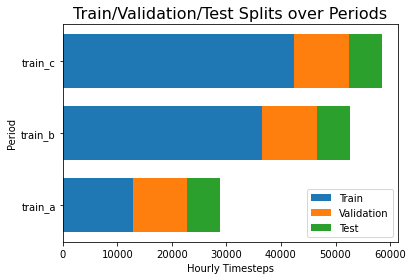

In [12]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

### Prepare data for training

We need to transform our dataset into a format suitable for training. We use the built-in keras function ``timeseries_dataset_from_array`` to make a generator that will yield batches of training data. We use sequence of length 128, i.e. around 5 days. We also choose the batch size to be 128. It is common to choose data sizes in neural networks to be a power of 2, in order to efficiently fit the data into the GPU memory. See here for details: https://datascience.stackexchange.com/questions/20179/what-is-the-advantage-of-keeping-batch-size-a-power-of-2

In [13]:
import tensorflow as tf


data_config = {
    "timesteps": 128,
    "batch_size": 128,
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 713
Number of val batches: 231


### Define the model

The model consists of a bidirectional LSTM layer followed by a bidirectional GRU layer. These layers process each timestep in sequence, and each output is combined with the next step's input. The LSTM and GRU cells contain "forget gates" which allow old data to be discarded when it is no longer relevant, while preserving relevant data indefinitely. This allows us to process long sequences without the gradients "exploding" (becoming very large, due to repeated application of a non-linear function to an input), which was a problem in older recurrent neural network architectures.

The LSTM architecture is more complex and requires more parameters than the GRU, so we use a smaller number of units in the LSTM to keep the computation feasible.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, Embedding, Input, Flatten
from tensorflow.keras.models import Sequential
import keras

The model defined in the next cell is never trained. Its purpose is to initialize the random number generators used in setting the initial model weights to a particular state, before training the real model.

In [15]:
from tensorflow.keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, GlobalAveragePooling1D,Input,Concatenate,Flatten,Embedding,Reshape,Conv1D,TimeDistributed,BatchNormalization,GaussianNoise
from tensorflow.keras.models import Sequential

# define dummy model
model_config = {"n_epochs": 100, "n_neurons": 244*2 , "dropout": 0.0, "stateful": False}

input1 = Input(shape=( data_config["timesteps"], len(XCOLS)), name='x1')
lstm1= Bidirectional(LSTM(
        model_config["n_neurons"],
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],return_sequences=True
    ))(input1)
gru1= Bidirectional(GRU(
         model_config["n_neurons"] *3,     
        stateful=model_config["stateful"],
        dropout=0.0,return_sequences=True
    ))(lstm1)

gaverage = Flatten() (gru1)
dense1 = Dense(96)(gaverage)
dense1 = Dense(128)(dense1)
dense1 = Dense(64)(dense1)
dense = Dense(2)(dense1)


model = keras.models.Model(inputs=input1, outputs=dense)
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(0.0001),
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x1 (InputLayer)              [(None, 128, 29)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 976)          2022272   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 2928)         21450528  
_________________________________________________________________
flatten (Flatten)            (None, 374784)            0         
_________________________________________________________________
dense (Dense)                (None, 96)                35979360  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12416     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256  

The following is the model that we will train.

In [16]:
from tensorflow.keras.layers import Dense, LSTM,GRU, Bidirectional, Dropout, GlobalAveragePooling1D,Input,Concatenate,Flatten,Embedding,Reshape,Conv1D,TimeDistributed,BatchNormalization,GaussianNoise
from tensorflow.keras.models import Sequential

# define our model
model_config = {"n_epochs": 30, "n_neurons": 192*2 , "dropout": 0.0, "stateful": False}

input1 = Input(shape=( data_config["timesteps"], len(XCOLS)), name='x1')
lstm1= Bidirectional(LSTM(
        model_config["n_neurons"],
        stateful=model_config["stateful"],
        dropout=model_config["dropout"],return_sequences=True
    ))(input1)
gru1= Bidirectional(GRU(
         model_config["n_neurons"] *3,   
        stateful=model_config["stateful"],
        dropout=0.0,return_sequences=True
    ))(lstm1)

gaverage = Flatten() (gru1)
dense1 = Dense(96)(gaverage)
dense1 = Dense(128)(dense1)
dense1 = Dense(64)(dense1)
dense = Dense(2)(dense1)


model = keras.models.Model(inputs=input1, outputs=dense)
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(0.0001),
)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x1 (InputLayer)              [(None, 128, 29)]         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 768)          1271808   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128, 2304)         13284864  
_________________________________________________________________
flatten_1 (Flatten)          (None, 294912)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 96)                28311648  
_________________________________________________________________
dense_5 (Dense)              (None, 128)               12416     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256

### Train the model

We now train the model. We use a callback to reduce the learning rate if the validation loss stops decreasing. We also use a callback to save the best iteration of the model.

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model2', save_best_only=True, monitor='val_loss', mode='min')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",factor=0.3, patience=4, min_lr=1e-10, mode='min')
history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs=model_config["n_epochs"],
    verbose=2,
    callbacks=[checkpoint, lr_reducer],
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/30
713/713 - 355s - loss: 122.1720 - val_loss: 219.7572


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 2/30
713/713 - 355s - loss: 104.8999 - val_loss: 192.0805


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 3/30
713/713 - 353s - loss: 94.0580 - val_loss: 169.1991


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 4/30
713/713 - 354s - loss: 84.8197 - val_loss: 146.4618


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 5/30
713/713 - 354s - loss: 84.4279 - val_loss: 148.1313
Epoch 6/30
713/713 - 355s - loss: 78.7631 - val_loss: 143.8925


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 7/30
713/713 - 356s - loss: 71.3374 - val_loss: 142.3542


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 8/30
713/713 - 356s - loss: 71.3404 - val_loss: 140.3080


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 9/30
713/713 - 355s - loss: 66.1611 - val_loss: 142.8691
Epoch 10/30
713/713 - 374s - loss: 62.2666 - val_loss: 139.7854


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 11/30
713/713 - 359s - loss: 58.5038 - val_loss: 140.6253
Epoch 12/30
713/713 - 356s - loss: 56.4332 - val_loss: 138.6808


INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


Epoch 13/30
713/713 - 354s - loss: 55.7577 - val_loss: 140.5640
Epoch 14/30
713/713 - 355s - loss: 60.5274 - val_loss: 139.4082
Epoch 15/30
713/713 - 356s - loss: 50.9204 - val_loss: 140.4509
Epoch 16/30
713/713 - 358s - loss: 48.4263 - val_loss: 142.4143
Epoch 17/30
713/713 - 355s - loss: 45.3930 - val_loss: 142.3511
Epoch 18/30
713/713 - 355s - loss: 40.4775 - val_loss: 146.2337
Epoch 19/30
713/713 - 355s - loss: 37.9661 - val_loss: 149.9650
Epoch 20/30
713/713 - 355s - loss: 35.9944 - val_loss: 150.7299
Epoch 21/30
713/713 - 356s - loss: 36.5886 - val_loss: 149.8961
Epoch 22/30
713/713 - 356s - loss: 35.1233 - val_loss: 149.0622
Epoch 23/30
713/713 - 354s - loss: 33.9721 - val_loss: 149.1151
Epoch 24/30


Load the best iteration of the model, which was saved by the callback.

In [32]:
model = keras.models.load_model("model2")

The training graph shows that the model seems to have converged.

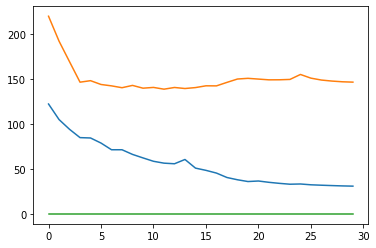

In [34]:
for name, values in history.history.items():
    plt.plot(values)

### Measure performance on private dataset

Now we load the private data, and measure the model's performance.

In [35]:
DATA_PATH = Path("data/private")
dst_private = pd.read_csv(DATA_PATH / "dst_labels.csv")
sunspots_private = pd.read_csv(DATA_PATH / "sunspots.csv")
solar_wind_private = pd.read_csv(DATA_PATH / "solar_wind.csv")

dst_private.timedelta = pd.to_timedelta(dst_private.timedelta)
dst_private.set_index(["period", "timedelta"], inplace=True)
sunspots_private.timedelta = pd.to_timedelta(sunspots_private.timedelta)
sunspots_private.set_index(["period", "timedelta"], inplace=True)
solar_wind_private.timedelta = pd.to_timedelta(solar_wind_private.timedelta)
solar_wind_private.set_index(["period", "timedelta"], inplace=True)
solar_wind_private.loc[solar_wind_private["temperature"] < 1, "temperature"] = np.nan

solar_wind_private.reset_index()
solar_wind_private.join(sunspots_private).join(dst_private)
features_private, scaler, imputer = preprocess_features(solar_wind_private, sunspots_private , subset=SOLAR_WIND_FEATURES, scaler=scaler)
private_labels = process_labels(dst_private)
private_data = private_labels.join(features_private)

In [36]:
private_test_ds = timeseries_dataset_from_df(private_data, data_config["batch_size"])

In [37]:
mse = model.evaluate(private_test_ds)
print(f"Private test RMSE: {mse**.5:.2f}")

458/458 [==============================] - 73s 157ms/step - loss: 147.9916
Private test RMSE: 12.17


In [38]:
preds = model.predict(private_test_ds)

# iterate through periods
dst_test_arr = []
for _, period_df in private_data.groupby("period"):
    # realign features and labels so that first sequence of 32 is aligned with the 33rd target
    outputs = period_df[YCOLS][128:]
    dst_test_arr.append(outputs.iloc[:-127, :])

dst_test = pd.concat(dst_test_arr, axis=0)
dst_test.columns = ["dst", "dst_t_plus_1"]
dst_test.reset_index(inplace=True)
dst_test[["prediction_t", "prediction_t_plus_1"]] = preds

### Measure performance in different DST ranges

Although the RMSE gives an indication of model performance, for pratical applications we are mainly interested in accurate predictions during storm events, i.e. when the DST has a large negative value. Below we plot the performance binned by DST ranges.

Unfortunately, it is difficult to accurately estimate performance at extreme times because storm events are very rare. We also show below the number of hourly values in each range; note that since storm events typically last 1-2 days, most of these hours occur very close to each other, and thus do not really represent distinct events.

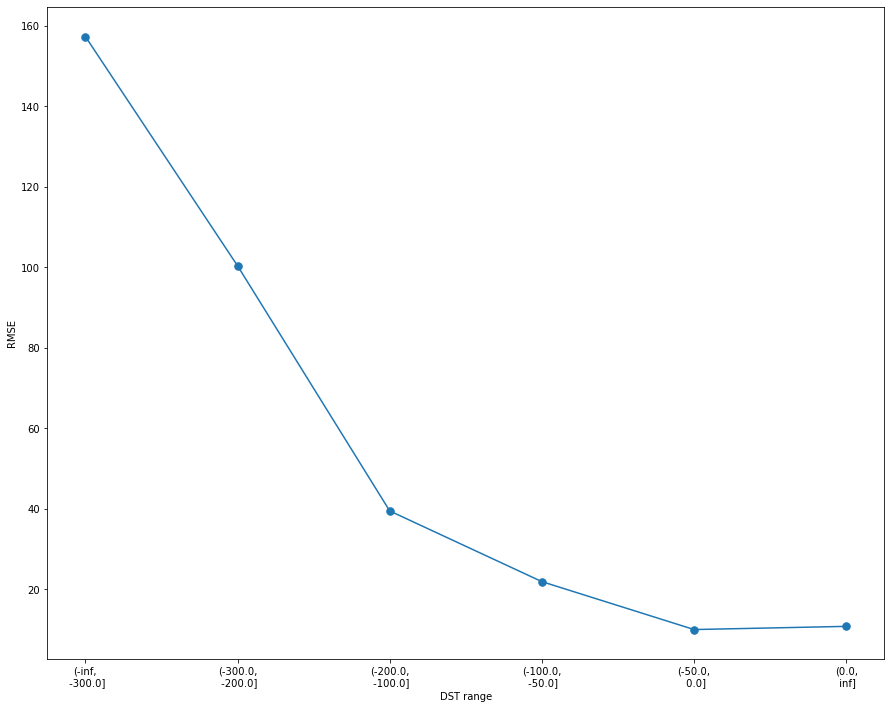

In [39]:
# define plotting function
def plot_binned_RMSE(actual: np.ndarray, predicted: np.ndarray, bin_edges):
    """Produce a plot of RMSE, binned by dst range.

    Args:
        actual: true values of dst
        predicted: predicted values of dst
        bin_edges: edges of the bins by which to group the data
    """

    df = pd.DataFrame({"actual": actual, "predicted": predicted})
    df["bin"] = pd.cut(df["actual"], bin_edges)
    df["sq_err"] = (df["actual"] - df["predicted"]) ** 2
    RMSE_by_bin = np.sqrt(df.groupby("bin")["sq_err"].mean())
    plt.plot(RMSE_by_bin.values, marker='.', markersize=15)
    labels = [s.replace(",", ",\n") for s in RMSE_by_bin.index.astype(str).values]
    plt.xticks(ticks=np.arange(len(RMSE_by_bin)), labels=labels)
    plt.xlabel("DST range")
    plt.ylabel("RMSE")

# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test[ "dst"].values, dst_test["prediction_t"].values, bins)

### Exploring the performance at storm events

Here we plot some graphs showing how the model performs during storm events.

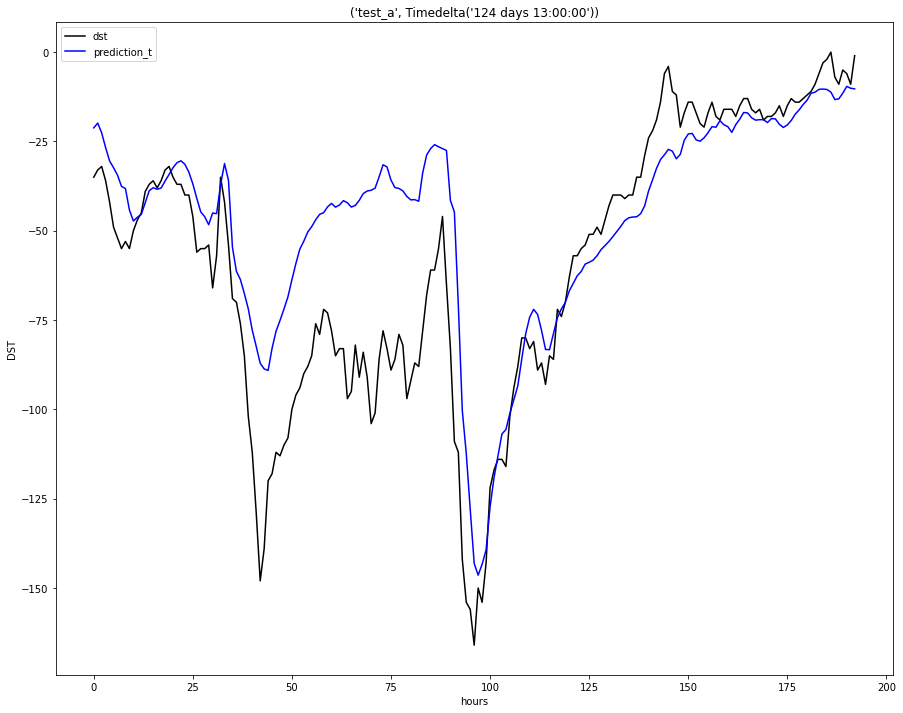

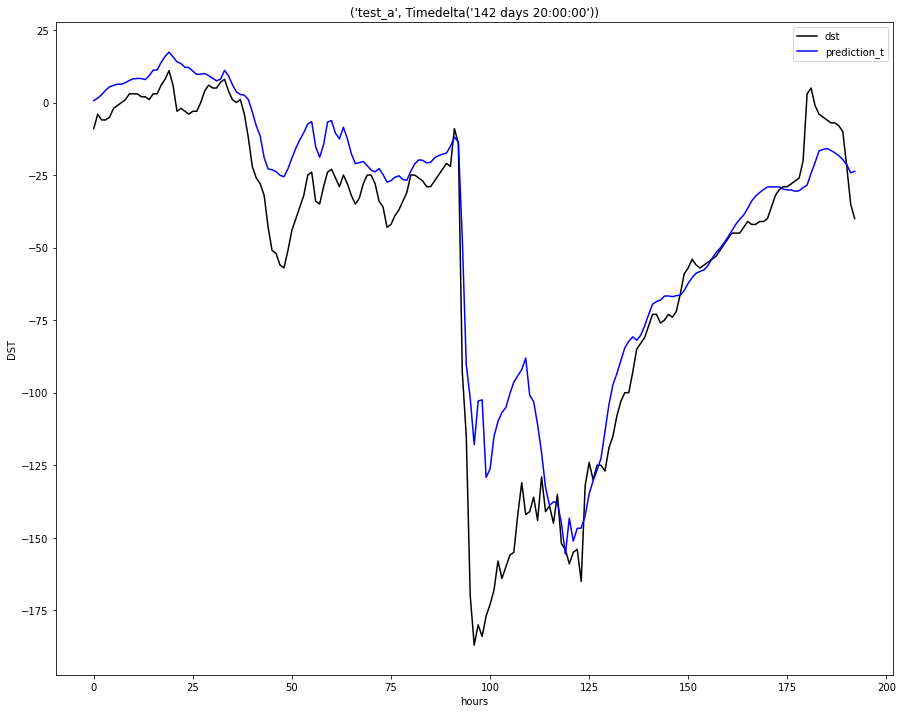

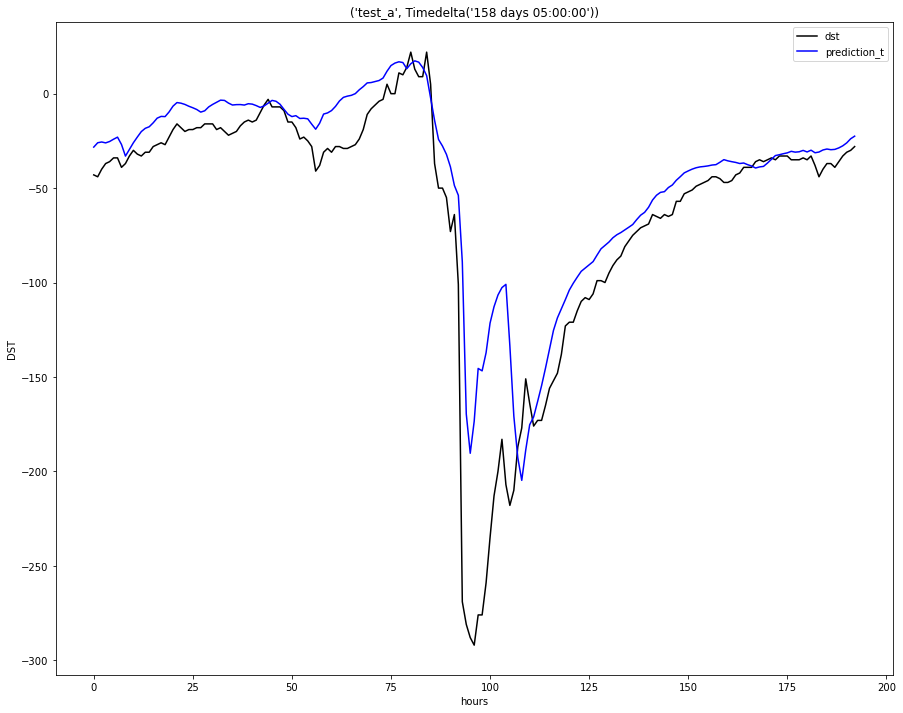

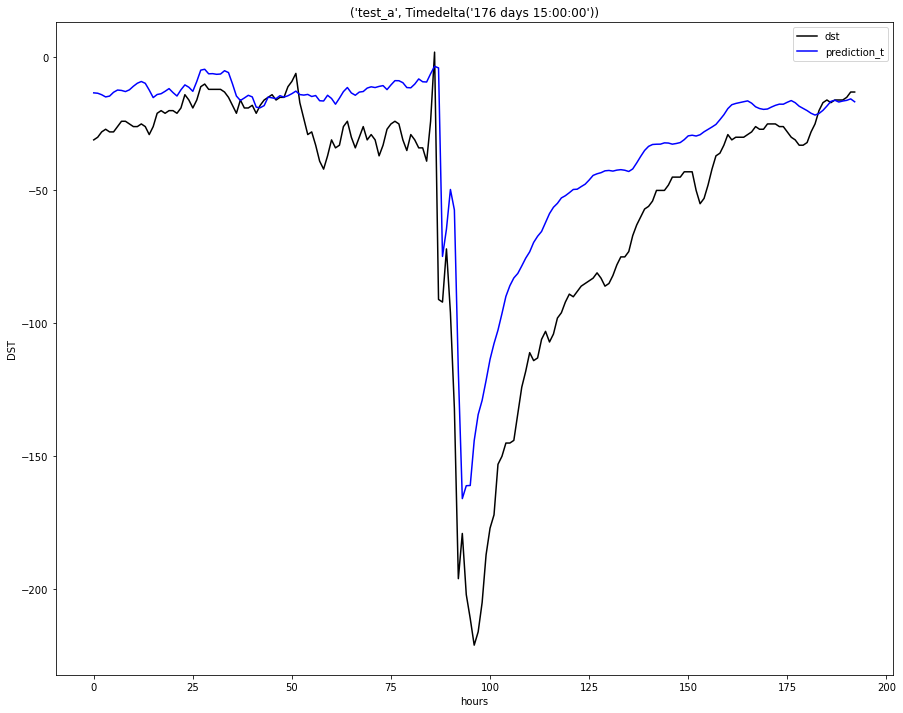

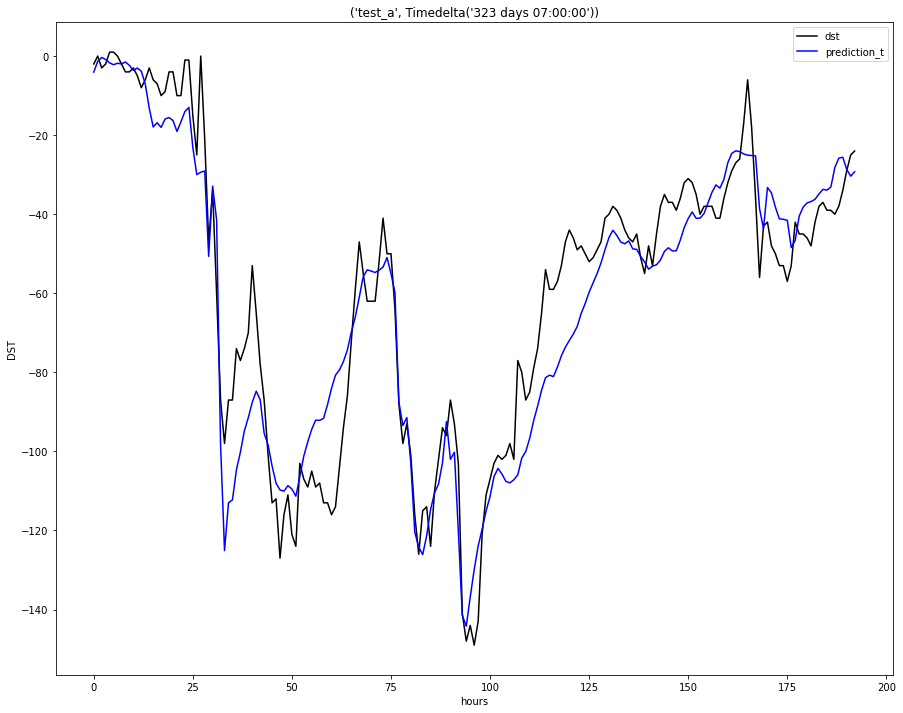

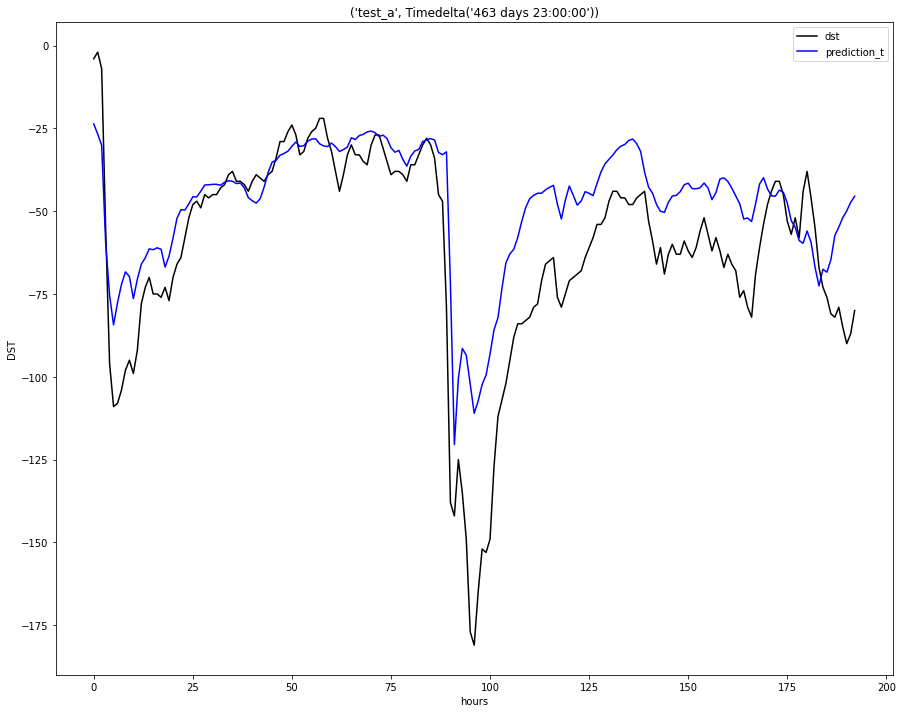

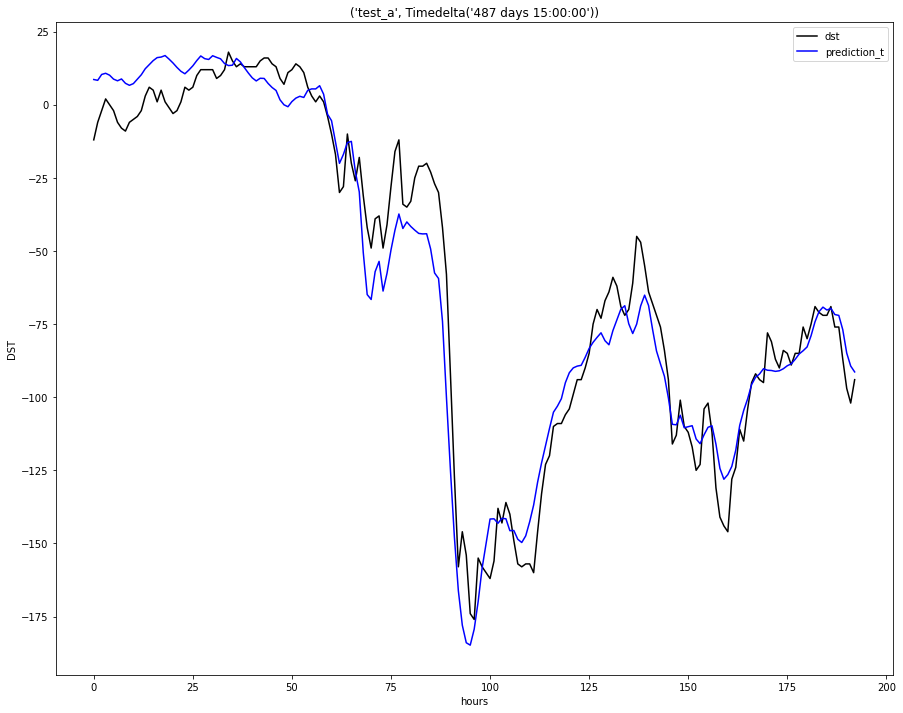

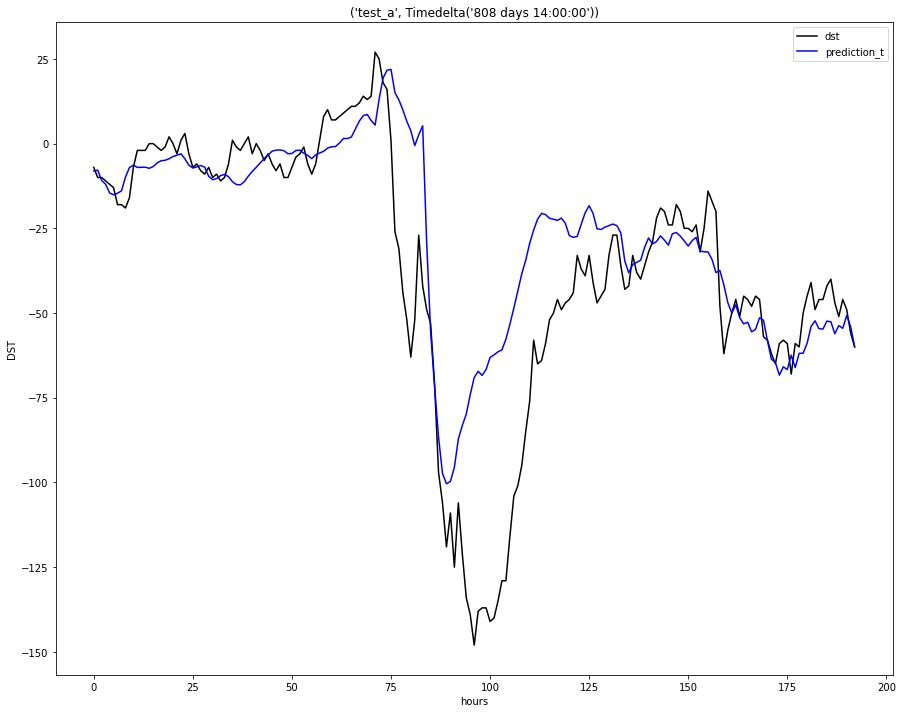

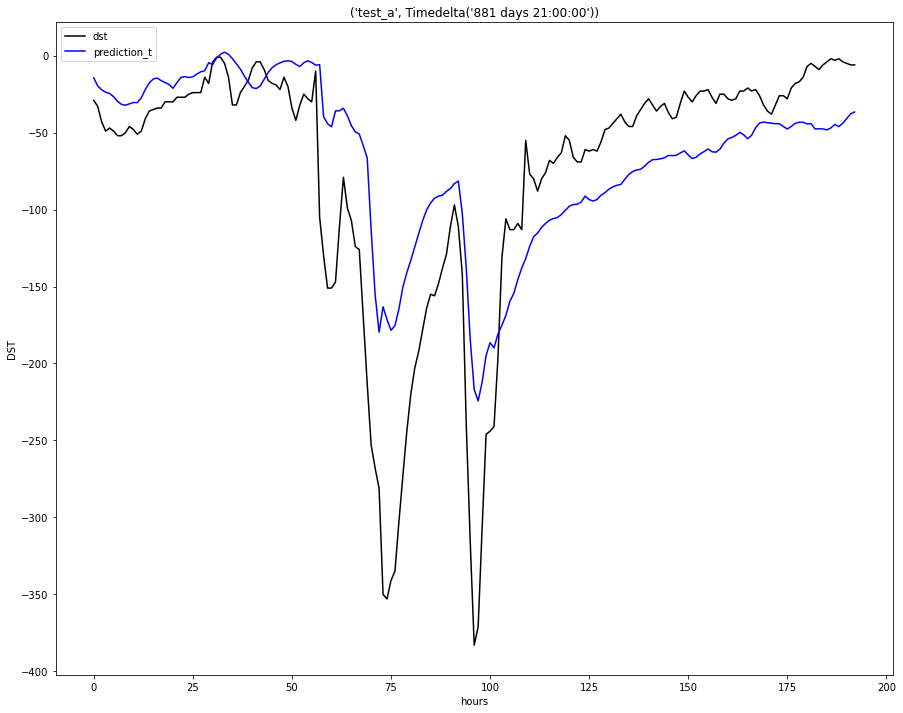

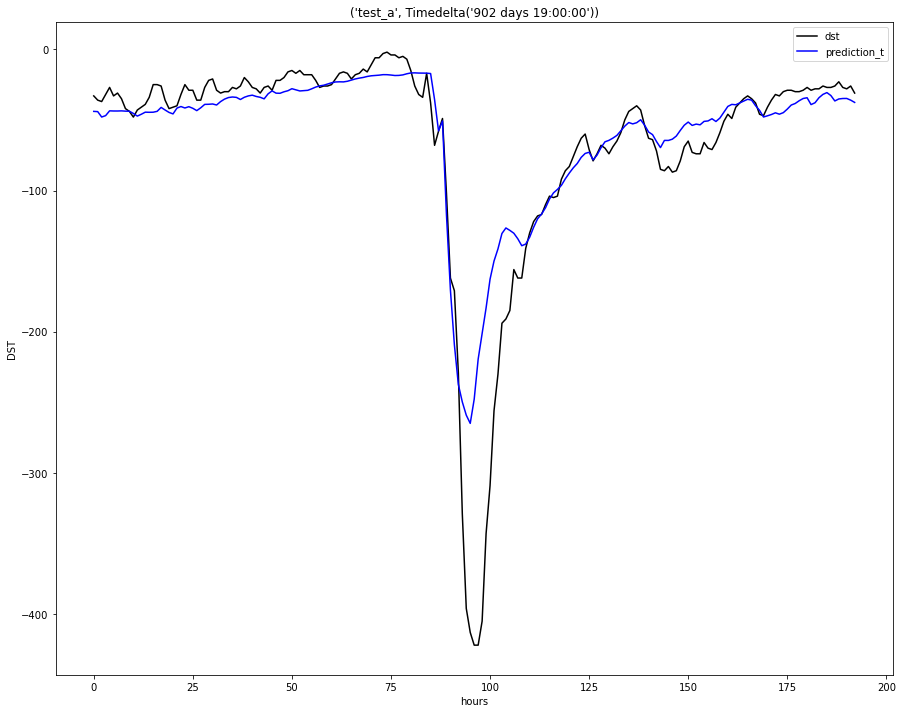

In [40]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_t"].values, c="blue")
    plt.legend(["dst", "prediction_t"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")